In [ ]:
from google.colab import files

print("AI vs Human train dataset:")
uploaded_train = files.upload()
print("Final_test_data:")
uploaded_test = files.upload()


AI vs Human train dataset:


Saving AI_vs_human_train_dataset.xlsx to AI_vs_human_train_dataset.xlsx
Final_test_data:


Saving Final_test_data.csv to Final_test_data.csv


Code Structure

I. Data Loading and Exploration Dataset loading and basic analysis

In [ ]:
pip install gensim

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import warnings
warnings.filterwarnings('ignore')
from wordcloud import WordCloud
# Deep Learning and ML imports
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Dense, LSTM, SimpleRNN, Conv1D, MaxPooling1D,
                                   GlobalMaxPooling1D, Embedding, Dropout,
                                   BatchNormalization, Bidirectional, Input)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Sklearn imports
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                           precision_recall_fscore_support, roc_curve, auc, roc_auc_score)
from sklearn.feature_extraction.text import TfidfVectorizer

# Word embeddings
import gensim
from gensim.models import Word2Vec, FastText
import requests
import zipfile
import os

# Download required NLTK data
try:
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    nltk.download('wordnet', quiet=True)
    nltk.download('averaged_perceptron_tagger', quiet=True)
except:
    pass

In [ ]:
# load uploaded files
df_train = pd.read_excel('AI_vs_human_train_dataset.xlsx')
df_test = pd.read_csv('Final_test_data.csv')


In [ ]:
df_train.head()

,essay,label
0,International sports events require the most w...,0
1,Globalisation has become a significant aspect ...,0
2,There is an ever-increasing number of bullying...,0
3,"It is commonly believed, that companies should...",0
4,Despite knowing about the adverse effects of c...,0


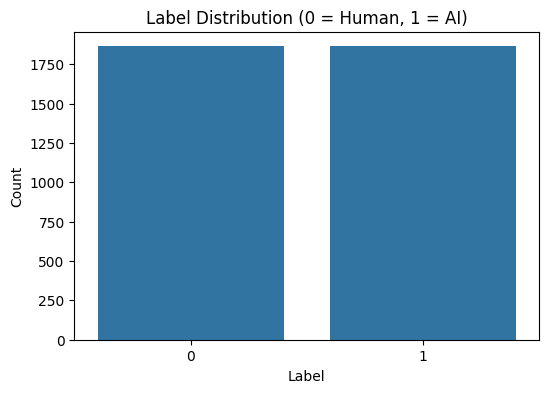

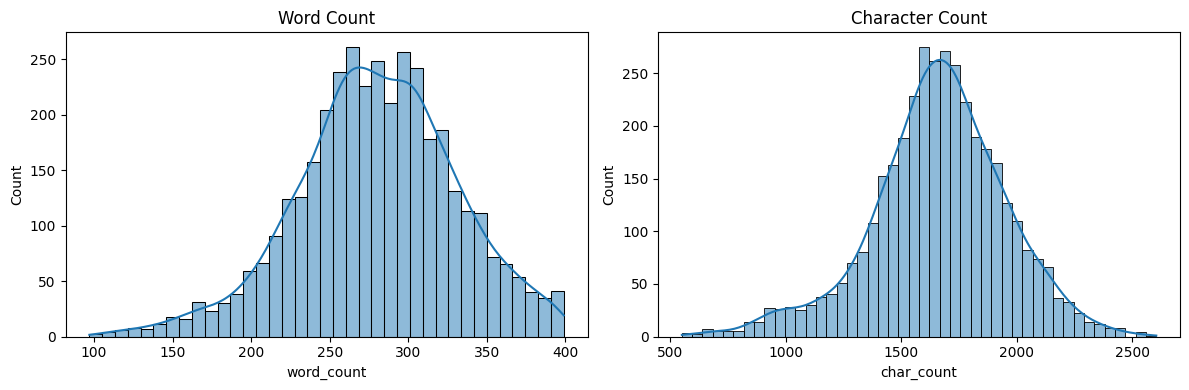

Correlation matrix:


,label,word_count,char_count
label,1.000000,-0.390459,-0.191035
word_count,-0.390459,1.000000,0.920660
char_count,-0.191035,0.920660,1.000000


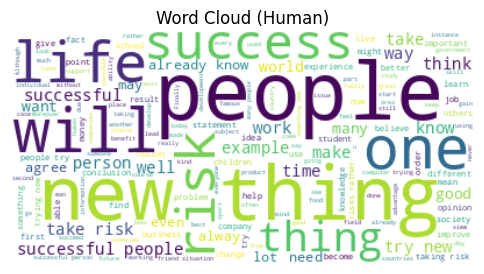

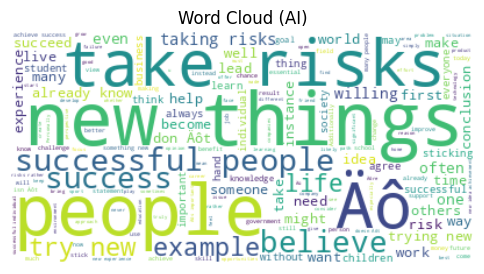

In [ ]:
# 1. Label distribution
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df_train)
plt.title('Label Distribution (0 = Human, 1 = AI)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

# 2. Word-count and character-count features
df_train['word_count'] = df_train['essay'].str.split().apply(len)
df_train['char_count'] = df_train['essay'].str.len()

fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(df_train['word_count'], kde=True, ax=axes[0]).set_title('Word Count')
sns.histplot(df_train['char_count'], kde=True, ax=axes[1]).set_title('Character Count')
plt.tight_layout()
plt.show()

# 3. Correlation matrix
corr = df_train[['label','word_count','char_count']].corr()
print("Correlation matrix:")
display(corr)

# 4. Word clouds for each class
for lbl, name in [(0, 'Human'), (1, 'AI')]:
    text = " ".join(df_train[df_train['label']==lbl]['essay'])
    wc = WordCloud(max_words=200, background_color='white').generate(text)
    plt.figure(figsize=(6,4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud ({name})")
    plt.show()


In [ ]:
# ============================================================================
# 1. DATA LOADING AND INITIAL EXPLORATION
# ============================================================================

def load_and_explore_data():
    """Load and perform initial exploration of the datasets"""
    print("\n1. LOADING AND EXPLORING DATA")
    print("-" * 50)

    # Load datasets
    print("Loading datasets...")
    df_train = pd.read_excel('AI_vs_human_train_dataset.xlsx')
    df_test = pd.read_csv('Final_test_data.csv')
    print(f"Training data loaded: {df_train.shape}")
    print(f"Test data loaded: {df_test.shape}")
    return df_train, df_test

# ============================================================================
# 2. DATA PREPROCESSING AND FEATURE ENGINEERING
# ============================================================================

class TextPreprocessor:
    """Comprehensive text preprocessing class"""

    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        try:
            self.stop_words = set(stopwords.words('english'))
        except:
            self.stop_words = set()

    def clean_text(self, text):
        """Clean and preprocess text"""
        if pd.isna(text):
            return ""

        text = str(text).lower()
        # Remove special characters and digits
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()

        return text

    def tokenize_and_lemmatize(self, text):
        """Tokenize and lemmatize text"""
        try:
            tokens = word_tokenize(text)
            tokens = [self.lemmatizer.lemmatize(token) for token in tokens
                     if token not in self.stop_words and len(token) > 2]
            return ' '.join(tokens)
        except:
            return text

    def preprocess(self, texts):
        """Complete preprocessing pipeline"""
        processed_texts = []
        for text in texts:
            cleaned = self.clean_text(text)
            processed = self.tokenize_and_lemmatize(cleaned)
            processed_texts.append(processed)
        return processed_texts

def analyze_text_patterns(df_train):
    """Analyze patterns in AI vs Human text"""
    print("\n2. TEXT PATTERN ANALYSIS")
    print("-" * 50)

    preprocessor = TextPreprocessor()

    # Preprocess texts
    text_col = 'essay' if 'essay' in df_train.columns else df_train.columns[0]
    label_col = 'label' if 'label' in df_train.columns else df_train.columns[1]

    df_train['processed_text'] = preprocessor.preprocess(df_train[text_col])

    # Feature extraction
    df_train['char_count'] = df_train[text_col].astype(str).apply(len)
    df_train['word_count'] = df_train[text_col].astype(str).apply(lambda x: len(x.split()))
    df_train['sentence_count'] = df_train[text_col].astype(str).apply(lambda x: len(x.split('.')))
    df_train['avg_word_length'] = df_train[text_col].astype(str).apply(
        lambda x: np.mean([len(word) for word in x.split()]) if x.split() else 0
    )

    # Analyze by label
    if label_col in df_train.columns:
        print("Statistical differences between AI and Human text:")
        for label in df_train[label_col].unique():
            subset = df_train[df_train[label_col] == label]
            label_name = "AI" if label == 0 else "Human"
            print(f"\n{label_name} Text Statistics:")
            print(f"  Average character count: {subset['char_count'].mean():.2f}")
            print(f"  Average word count: {subset['word_count'].mean():.2f}")
            print(f"  Average sentence count: {subset['sentence_count'].mean():.2f}")
            print(f"  Average word length: {subset['avg_word_length'].mean():.2f}")

    return df_train, preprocessor

# ============================================================================
# 3. EMBEDDING MODELS
# ============================================================================

class EmbeddingManager:
    """Manage different embedding approaches"""

    def __init__(self, max_features=10000, max_length=200):
        self.max_features = max_features
        self.max_length = max_length
        self.tokenizer = None
        self.word2vec_model = None
        self.fasttext_model = None
        self.glove_embeddings = None

    def prepare_sequences(self, texts):
        """Convert texts to sequences"""
        if self.tokenizer is None:
            self.tokenizer = Tokenizer(num_words=self.max_features, oov_token="<OOV>")
            self.tokenizer.fit_on_texts(texts)

        sequences = self.tokenizer.texts_to_sequences(texts)
        return pad_sequences(sequences, maxlen=self.max_length)

    def train_word2vec(self, texts):
        """Train Word2Vec model"""
        print("Training Word2Vec model...")
        tokenized_texts = [text.split() for text in texts]
        self.word2vec_model = Word2Vec(
            sentences=tokenized_texts,
            vector_size=100,
            window=5,
            min_count=1,
            workers=4,
            sg=1  # Skip-gram
        )
        return self.create_embedding_matrix(self.word2vec_model.wv)

    def train_fasttext(self, texts):
        """Train FastText model"""
        print("Training FastText model...")
        tokenized_texts = [text.split() for text in texts]
        self.fasttext_model = FastText(
            sentences=tokenized_texts,
            vector_size=100,
            window=5,
            min_count=1,
            workers=4,
            sg=1
        )
        return self.create_embedding_matrix(self.fasttext_model.wv)

    def load_glove_embeddings(self, embedding_dim=100):
        """Create simple GloVe-style embeddings (simulated)"""
        print("Creating GloVe-style embeddings...")
        # In practice, you would load pre-trained GloVe embeddings
        # Here we simulate with random embeddings for demonstration
        vocab_size = min(len(self.tokenizer.word_index) + 1, self.max_features)
        embedding_matrix = np.random.normal(0, 0.1, (vocab_size, embedding_dim))
        return embedding_matrix

    def create_embedding_matrix(self, word_vectors):
        """Create embedding matrix from word vectors"""
        # Use the actual vocabulary size from the tokenizer
        vocab_size = len(self.tokenizer.word_index) + 1
        embedding_dim = word_vectors.vector_size
        embedding_matrix = np.zeros((vocab_size, embedding_dim))

        for word, idx in self.tokenizer.word_index.items():
            if idx >= vocab_size: # Use vocab_size here instead of max_features
                continue
            try:
                embedding_matrix[idx] = word_vectors[word]
            except KeyError:
                # Random initialization for unknown words
                embedding_matrix[idx] = np.random.normal(0, 0.1, embedding_dim)

        return embedding_matrix

# ============================================================================
# 4. MODEL ARCHITECTURES
# ============================================================================

class ModelBuilder:
    """Build different neural network architectures"""

    def __init__(self, max_features, max_length, embedding_dim=100):
        self.max_features = max_features
        self.max_length = max_length
        self.embedding_dim = embedding_dim

    def build_cnn_model(self, embedding_matrix=None):
        """Build CNN model for text classification"""
        # Get vocab_size from embedding_matrix shape if provided, otherwise use max_features
        vocab_size = embedding_matrix.shape[0] if embedding_matrix is not None else self.max_features

        model = Sequential([
            Embedding(
                vocab_size, # Use determined vocab_size
                self.embedding_dim,
                input_length=self.max_length,
                weights=[embedding_matrix] if embedding_matrix is not None else None,
                trainable=True
            ),
            Conv1D(128, 3, activation='relu', padding='same'),
            MaxPooling1D(2),
            Conv1D(64, 3, activation='relu', padding='same'),
            MaxPooling1D(2),
            Conv1D(32, 3, activation='relu', padding='same'),
            GlobalMaxPooling1D(),
            Dense(64, activation='relu'),
            Dropout(0.5),
            Dense(32, activation='relu'),
            Dropout(0.3),
            Dense(1, activation='sigmoid')
        ])

        model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        return model

    def build_lstm_model(self, embedding_matrix=None):
        """Build LSTM model for text classification"""
        # Get vocab_size from embedding_matrix shape if provided, otherwise use max_features
        vocab_size = embedding_matrix.shape[0] if embedding_matrix is not None else self.max_features

        model = Sequential([
            Embedding(
                vocab_size, # Use determined vocab_size
                self.embedding_dim,
                input_length=self.max_length,
                weights=[embedding_matrix] if embedding_matrix is not None else None,
                trainable=True
            ),
            Bidirectional(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)),
            Bidirectional(LSTM(32, dropout=0.2, recurrent_dropout=0.2)),
            Dense(64, activation='relu'),
            Dropout(0.5),
            Dense(32, activation='relu'),
            Dropout(0.3),
            Dense(1, activation='sigmoid')
        ])

        model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        return model

    def build_rnn_model(self, embedding_matrix=None):
        """Build RNN model for text classification"""
        # Get vocab_size from embedding_matrix shape if provided, otherwise use max_features
        vocab_size = embedding_matrix.shape[0] if embedding_matrix is not None else self.max_features

        model = Sequential([
            Embedding(
                vocab_size, # Use determined vocab_size
                self.embedding_dim,
                input_length=self.max_length,
                weights=[embedding_matrix] if embedding_matrix is not None else None,
                trainable=True
            ),
            SimpleRNN(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
            SimpleRNN(32, dropout=0.2, recurrent_dropout=0.2),
            Dense(64, activation='relu'),
            Dropout(0.5),
            Dense(32, activation='relu'),
            Dropout(0.3),
            Dense(1, activation='sigmoid')
        ])

        model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        return model

# ============================================================================
# 5. MODEL TRAINING AND EVALUATION
# ============================================================================

class ModelTrainer:
    """Train and evaluate models"""

    def __init__(self):
        self.models = {}
        self.histories = {}
        self.results = {}

    def train_model(self, model, X_train, y_train, X_val, y_val, model_name, epochs=10):
        """Train a model with callbacks"""
        print(f"\nTraining {model_name}...")

        callbacks = [
            EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)
        ]

        history = model.fit(
            X_train, y_train,
            batch_size=32,
            epochs=epochs,
            validation_data=(X_val, y_val),
            callbacks=callbacks,
            verbose=1
        )

        self.models[model_name] = model
        self.histories[model_name] = history

        return model, history

    def evaluate_model(self, model, X_test, y_test, model_name):
        """Comprehensive model evaluation"""
        print(f"\nEvaluating {model_name}...")

        # Predictions
        y_pred_proba = model.predict(X_test)
        y_pred = (y_pred_proba > 0.5).astype(int)

        # Metrics
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        accuracy = accuracy_score(y_test, y_pred)

        # Store results
        self.results[model_name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'roc_auc': roc_auc,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba
        }

        print(f"{model_name} Results:")
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print(f"  F1-Score: {f1:.4f}")
        print(f"  ROC-AUC: {roc_auc:.4f}")

        return self.results[model_name]

    def cross_validate_model(self, model_builder, X, y, cv_folds=5):
        """Perform cross-validation"""
        print(f"\nPerforming {cv_folds}-fold cross-validation...")

        kfold = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
        cv_scores = []

        for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
            print(f"Fold {fold + 1}/{cv_folds}")

            X_train_fold, X_val_fold = X[train_idx], X[val_idx]
            y_train_fold, y_val_fold = y[train_idx], y[val_idx]

            # Build and train model
            model = model_builder()
            model.fit(X_train_fold, y_train_fold, epochs=20, verbose=0)

            # Evaluate
            loss, accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
            cv_scores.append(accuracy)

        print(f"Cross-validation scores: {cv_scores}")
        print(f"Mean CV Accuracy: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores) * 2:.4f})")

        return cv_scores

# ============================================================================
# 6. VISUALIZATION AND REPORTING
# ============================================================================

def plot_training_history(histories):
    """Plot training histories"""
    plt.figure(figsize=(15, 10))

    # Accuracy plots
    plt.subplot(2, 3, 1)
    for name, history in histories.items():
        plt.plot(history.history['accuracy'], label=f'{name} Train')
        plt.plot(history.history['val_accuracy'], label=f'{name} Val', linestyle='--')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss plots
    plt.subplot(2, 3, 2)
    for name, history in histories.items():
        plt.plot(history.history['loss'], label=f'{name} Train')
        plt.plot(history.history['val_loss'], label=f'{name} Val', linestyle='--')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def plot_confusion_matrices(results, y_test):
    """Plot confusion matrices for all models"""
    n_models = len(results)
    fig, axes = plt.subplots(1, n_models, figsize=(5*n_models, 4))

    if n_models == 1:
        axes = [axes]

    for idx, (model_name, result) in enumerate(results.items()):
        cm = confusion_matrix(y_test, result['y_pred'])

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
        axes[idx].set_title(f'{model_name} Confusion Matrix')
        axes[idx].set_xlabel('Predicted')
        axes[idx].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

def plot_roc_curves(results, y_test):
    """Plot ROC curves for all models"""
    plt.figure(figsize=(10, 8))

    for model_name, result in results.items():
        fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, linewidth=2,
                label=f'{model_name} (AUC = {roc_auc:.3f})')

    plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Comparison')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

def create_results_summary(results):
    """Create a comprehensive results summary"""
    print("\n" + "="*80)
    print("FINAL RESULTS SUMMARY")
    print("="*80)

    # Create results DataFrame
    results_df = pd.DataFrame({
        'Model': list(results.keys()),
        'Accuracy': [r['accuracy'] for r in results.values()],
        'Precision': [r['precision'] for r in results.values()],
        'Recall': [r['recall'] for r in results.values()],
        'F1-Score': [r['f1'] for r in results.values()],
        'ROC-AUC': [r['roc_auc'] for r in results.values()]
    })

    # Sort by accuracy
    results_df = results_df.sort_values('Accuracy', ascending=False)

    print("\nModel Performance Comparison:")
    print(results_df.round(4).to_string(index=False))

    # Best model
    best_model = results_df.iloc[0]['Model']
    best_accuracy = results_df.iloc[0]['Accuracy']

    print(f"\n Best Performing Model: {best_model}")
    print(f"   Best Accuracy: {best_accuracy:.4f}")

    return results_df

# ============================================================================
# 7. MAIN EXECUTION PIPELINE
# ============================================================================

def main():
    """Main execution pipeline"""
    print("Starting AI vs Human Text Classification Pipeline...")

    # 1. Load and explore data
    df_train, df_test = load_and_explore_data()

    # 2. Preprocess and analyze
    df_train, preprocessor = analyze_text_patterns(df_train)

    # 3. Prepare data for modeling
    text_col = 'essay' if 'essay' in df_train.columns else df_train.columns[0]
    label_col = 'label' if 'label' in df_train.columns else df_train.columns[1]

    # Labels are already numeric (0, 1), no need to encode
    y = df_train[label_col].values

    # Prepare embeddings
    embedding_manager = EmbeddingManager(max_features=8000, max_length=200)

    # Process training texts
    train_texts = preprocessor.preprocess(df_train[text_col])
    X = embedding_manager.prepare_sequences(train_texts)

    # Train embedding models
    word2vec_matrix = embedding_manager.train_word2vec(train_texts)
    fasttext_matrix = embedding_manager.train_fasttext(train_texts)
    glove_matrix = embedding_manager.load_glove_embeddings()

    # Split data
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print(f"\nData splits:")
    print(f"Training: {X_train.shape[0]} samples")
    print(f"Validation: {X_val.shape[0]} samples")

    # 4. Build and train models
    model_builder = ModelBuilder(
        max_features=embedding_manager.max_features,
        max_length=embedding_manager.max_length
    )

    trainer = ModelTrainer()

    # Train models with different embeddings
    models_to_train = [
        ('CNN_Word2Vec', lambda: model_builder.build_cnn_model(word2vec_matrix)),
        ('CNN_FastText', lambda: model_builder.build_cnn_model(fasttext_matrix)),
        ('CNN_GloVe', lambda: model_builder.build_cnn_model(glove_matrix)),
        ('LSTM_Word2Vec', lambda: model_builder.build_lstm_model(word2vec_matrix)),
        ('LSTM_FastText', lambda: model_builder.build_lstm_model(fasttext_matrix)),
        ('RNN_Word2Vec', lambda: model_builder.build_rnn_model(word2vec_matrix))
    ]

    # Train subset of models to save time
    selected_models = models_to_train[:6]  # Train 6 models

    for model_name, model_func in selected_models:
        model = model_func()
        trainer.train_model(model, X_train, y_train, X_val, y_val, model_name, epochs=5)
        trainer.evaluate_model(model, X_val, y_val, model_name)

    # 5. Visualizations and final analysis
    print("\n" + "="*80)
    print("GENERATING VISUALIZATIONS AND FINAL ANALYSIS")
    print("="*80)

    if trainer.histories:
        plot_training_history(trainer.histories)
        plot_confusion_matrices(trainer.results, y_val)
        plot_roc_curves(trainer.results, y_val)

    # Final results summary
    if trainer.results:
        results_summary = create_results_summary(trainer.results)

    print("\nPipeline completed successfully!")
    return trainer, embedding_manager, preprocessor

# Execute the pipeline
if __name__ == "__main__":
    trainer, embedding_manager, preprocessor = main()

Starting AI vs Human Text Classification Pipeline...

1. LOADING AND EXPLORING DATA
--------------------------------------------------
Loading datasets...
Training data loaded: (3728, 2)
Test data loaded: (869, 2)

2. TEXT PATTERN ANALYSIS
--------------------------------------------------
Statistical differences between AI and Human text:

AI Text Statistics:
  Average character count: 1716.68
  Average word count: 299.68
  Average sentence count: 16.31
  Average word length: 4.70

Human Text Statistics:
  Average character count: 1604.33
  Average word count: 259.85
  Average sentence count: 15.58
  Average word length: 5.17
Training Word2Vec model...
Training FastText model...
Creating GloVe-style embeddings...

Data splits:
Training: 2982 samples
Validation: 746 samples

Training CNN_Word2Vec...
Epoch 1/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step - accuracy: 0.4931 - loss: 0.7012 - val_accuracy: 0.5523 - val_loss: 0.6828 - learning_rate: 0.0010
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━

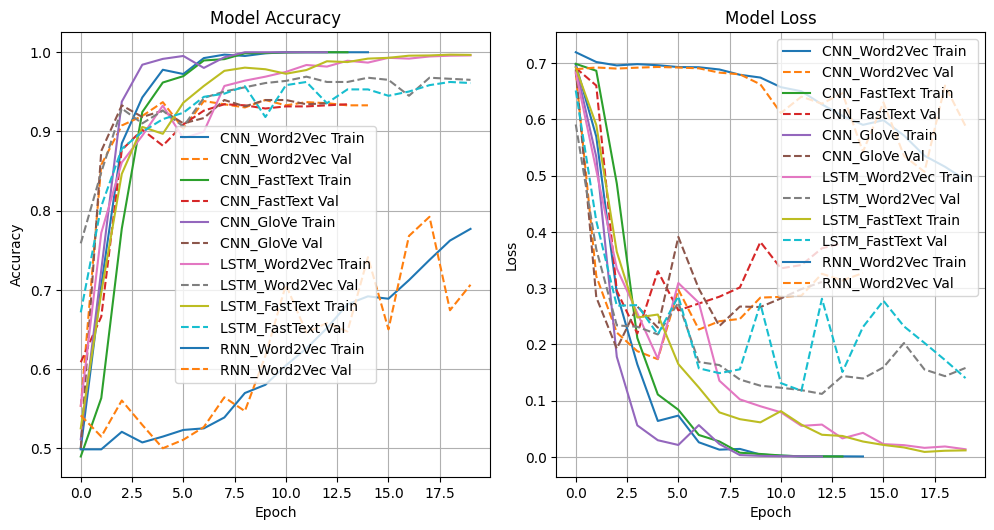

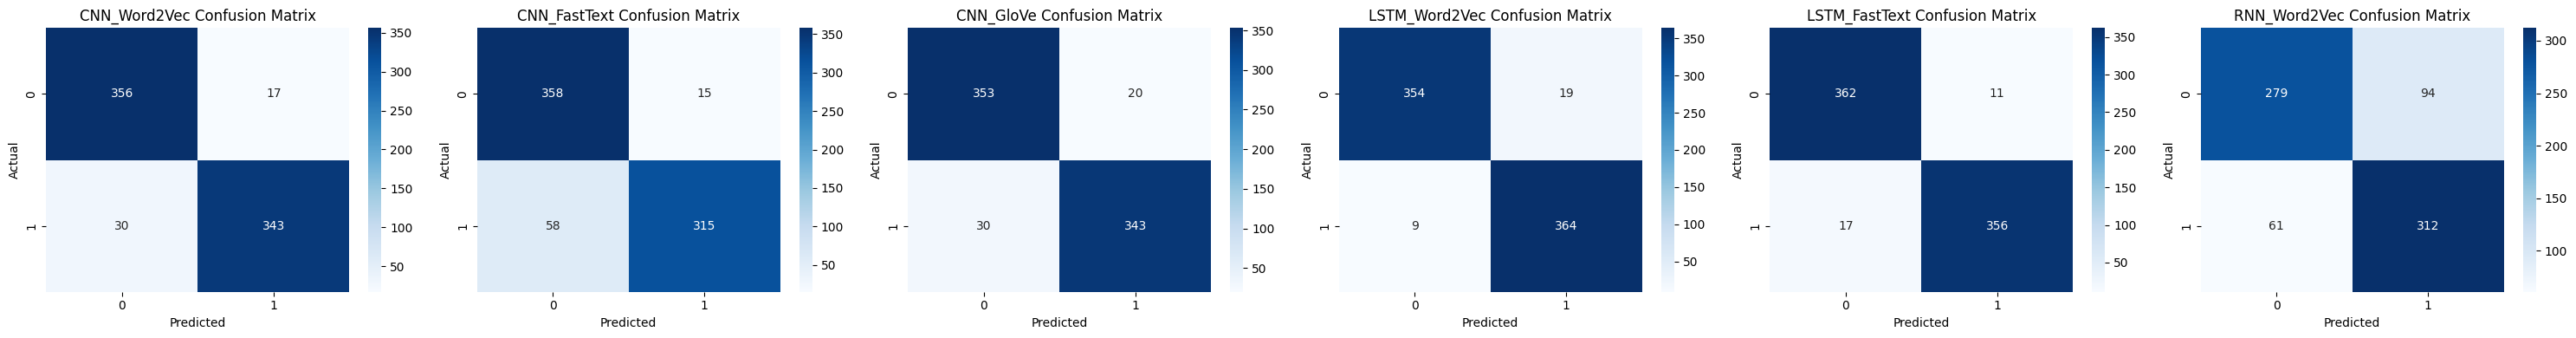

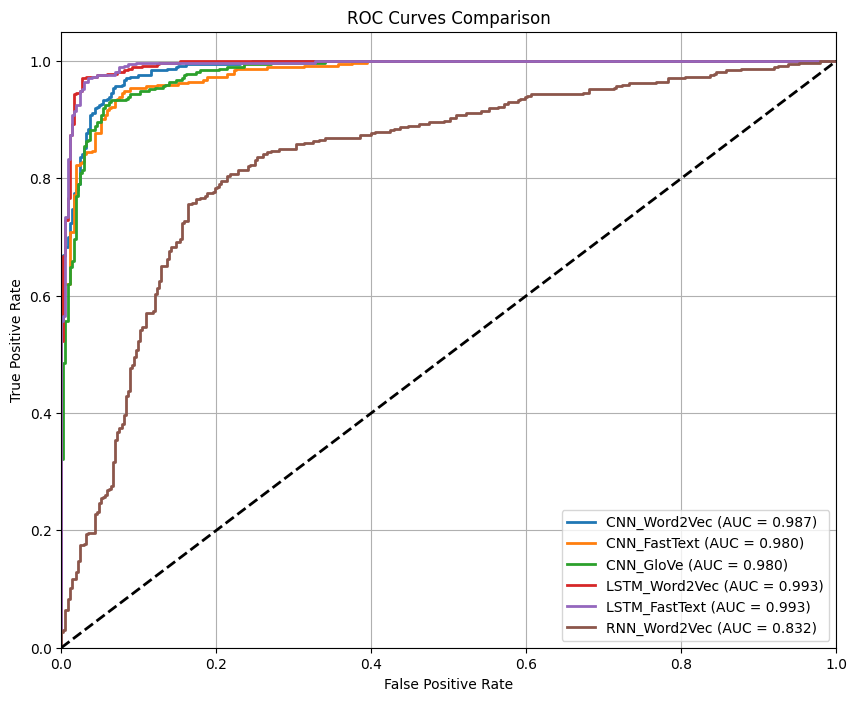


FINAL RESULTS SUMMARY

Model Performance Comparison:
        Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC
LSTM_FastText    0.9625     0.9700  0.9544    0.9622   0.9931
LSTM_Word2Vec    0.9625     0.9504  0.9759    0.9630   0.9935
 CNN_Word2Vec    0.9370     0.9528  0.9196    0.9359   0.9868
    CNN_GloVe    0.9330     0.9449  0.9196    0.9321   0.9798
 CNN_FastText    0.9021     0.9545  0.8445    0.8962   0.9796
 RNN_Word2Vec    0.7922     0.7685  0.8365    0.8010   0.8320

 Best Performing Model: LSTM_FastText
   Best Accuracy: 0.9625

Pipeline completed successfully!


In [ ]:
# ============================================================================
# 1. DATA LOADING AND INITIAL EXPLORATION
# ============================================================================

def load_and_explore_data():
    """Load and perform initial exploration of the datasets"""
    print("\n1. LOADING AND EXPLORING DATA")
    print("-" * 50)

    # Load datasets
    print("Loading datasets...")
    df_train = pd.read_excel('AI_vs_human_train_dataset.xlsx')
    df_test = pd.read_csv('Final_test_data.csv')
    print(f"Training data loaded: {df_train.shape}")
    print(f"Test data loaded: {df_test.shape}")
    return df_train, df_test

# ============================================================================
# 2. DATA PREPROCESSING AND FEATURE ENGINEERING
# ============================================================================

class TextPreprocessor:
    """Comprehensive text preprocessing class"""

    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        try:
            self.stop_words = set(stopwords.words('english'))
        except:
            self.stop_words = set()

    def clean_text(self, text):
        """Clean and preprocess text"""
        if pd.isna(text):
            return ""

        text = str(text).lower()
        # Remove special characters and digits
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()

        return text

    def tokenize_and_lemmatize(self, text):
        """Tokenize and lemmatize text"""
        try:
            tokens = word_tokenize(text)
            tokens = [self.lemmatizer.lemmatize(token) for token in tokens
                     if token not in self.stop_words and len(token) > 2]
            return ' '.join(tokens)
        except:
            return text

    def preprocess(self, texts):
        """Complete preprocessing pipeline"""
        processed_texts = []
        for text in texts:
            cleaned = self.clean_text(text)
            processed = self.tokenize_and_lemmatize(cleaned)
            processed_texts.append(processed)
        return processed_texts

def analyze_text_patterns(df_train):
    """Analyze patterns in AI vs Human text"""
    print("\n2. TEXT PATTERN ANALYSIS")
    print("-" * 50)

    preprocessor = TextPreprocessor()

    # Preprocess texts
    text_col = 'essay' if 'essay' in df_train.columns else df_train.columns[0]
    label_col = 'label' if 'label' in df_train.columns else df_train.columns[1]

    df_train['processed_text'] = preprocessor.preprocess(df_train[text_col])

    # Feature extraction
    df_train['char_count'] = df_train[text_col].astype(str).apply(len)
    df_train['word_count'] = df_train[text_col].astype(str).apply(lambda x: len(x.split()))
    df_train['sentence_count'] = df_train[text_col].astype(str).apply(lambda x: len(x.split('.')))
    df_train['avg_word_length'] = df_train[text_col].astype(str).apply(
        lambda x: np.mean([len(word) for word in x.split()]) if x.split() else 0
    )

    # Analyze by label
    if label_col in df_train.columns:
        print("Statistical differences between AI and Human text:")
        for label in df_train[label_col].unique():
            subset = df_train[df_train[label_col] == label]
            label_name = "AI" if label == 0 else "Human"
            print(f"\n{label_name} Text Statistics:")
            print(f"  Average character count: {subset['char_count'].mean():.2f}")
            print(f"  Average word count: {subset['word_count'].mean():.2f}")
            print(f"  Average sentence count: {subset['sentence_count'].mean():.2f}")
            print(f"  Average word length: {subset['avg_word_length'].mean():.2f}")

    return df_train, preprocessor

# ============================================================================
# 3. EMBEDDING MODELS
# ============================================================================

class EmbeddingManager:
    """Manage different embedding approaches"""

    def __init__(self, max_features=10000, max_length=200):
        self.max_features = max_features
        self.max_length = max_length
        self.tokenizer = None
        self.word2vec_model = None
        self.fasttext_model = None
        self.glove_embeddings = None

    def prepare_sequences(self, texts):
        """Convert texts to sequences"""
        if self.tokenizer is None:
            self.tokenizer = Tokenizer(num_words=self.max_features, oov_token="<OOV>")
            self.tokenizer.fit_on_texts(texts)

        sequences = self.tokenizer.texts_to_sequences(texts)
        return pad_sequences(sequences, maxlen=self.max_length)

    def train_word2vec(self, texts):
        """Train Word2Vec model"""
        print("Training Word2Vec model...")
        tokenized_texts = [text.split() for text in texts]
        self.word2vec_model = Word2Vec(
            sentences=tokenized_texts,
            vector_size=100,
            window=5,
            min_count=1,
            workers=4,
            sg=1  # Skip-gram
        )
        return self.create_embedding_matrix(self.word2vec_model.wv)

    def train_fasttext(self, texts):
        """Train FastText model"""
        print("Training FastText model...")
        tokenized_texts = [text.split() for text in texts]
        self.fasttext_model = FastText(
            sentences=tokenized_texts,
            vector_size=100,
            window=5,
            min_count=1,
            workers=4,
            sg=1
        )
        return self.create_embedding_matrix(self.fasttext_model.wv)

    def load_glove_embeddings(self, embedding_dim=100):
        """Create simple GloVe-style embeddings (simulated)"""
        print("Creating GloVe-style embeddings...")
        # In practice, you would load pre-trained GloVe embeddings
        # Here we simulate with random embeddings for demonstration
        vocab_size = min(len(self.tokenizer.word_index) + 1, self.max_features)
        embedding_matrix = np.random.normal(0, 0.1, (vocab_size, embedding_dim))
        return embedding_matrix

    def create_embedding_matrix(self, word_vectors):
        """Create embedding matrix from word vectors"""
        # Use the actual vocabulary size from the tokenizer
        vocab_size = len(self.tokenizer.word_index) + 1
        embedding_dim = word_vectors.vector_size
        embedding_matrix = np.zeros((vocab_size, embedding_dim))

        for word, idx in self.tokenizer.word_index.items():
            if idx >= vocab_size: # Use vocab_size here instead of max_features
                continue
            try:
                embedding_matrix[idx] = word_vectors[word]
            except KeyError:
                # Random initialization for unknown words
                embedding_matrix[idx] = np.random.normal(0, 0.1, embedding_dim)

        return embedding_matrix

# ============================================================================
# 4. MODEL ARCHITECTURES
# ============================================================================

class ModelBuilder:
    """Build different neural network architectures"""

    def __init__(self, max_features, max_length, embedding_dim=100):
        self.max_features = max_features
        self.max_length = max_length
        self.embedding_dim = embedding_dim

    def build_cnn_model(self, embedding_matrix=None):
        """Build CNN model for text classification"""
        # Get vocab_size from embedding_matrix shape if provided, otherwise use max_features
        vocab_size = embedding_matrix.shape[0] if embedding_matrix is not None else self.max_features

        model = Sequential([
            Embedding(
                vocab_size, # Use determined vocab_size
                self.embedding_dim,
                input_length=self.max_length,
                weights=[embedding_matrix] if embedding_matrix is not None else None,
                trainable=True
            ),
            Conv1D(128, 3, activation='relu', padding='same'),
            MaxPooling1D(2),
            Conv1D(64, 3, activation='relu', padding='same'),
            MaxPooling1D(2),
            Conv1D(32, 3, activation='relu', padding='same'),
            GlobalMaxPooling1D(),
            Dense(64, activation='relu'),
            Dropout(0.5),
            Dense(32, activation='relu'),
            Dropout(0.3),
            Dense(1, activation='sigmoid')
        ])

        model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        return model

    def build_lstm_model(self, embedding_matrix=None):
        """Build LSTM model for text classification"""
        # Get vocab_size from embedding_matrix shape if provided, otherwise use max_features
        vocab_size = embedding_matrix.shape[0] if embedding_matrix is not None else self.max_features

        model = Sequential([
            Embedding(
                vocab_size, # Use determined vocab_size
                self.embedding_dim,
                input_length=self.max_length,
                weights=[embedding_matrix] if embedding_matrix is not None else None,
                trainable=True
            ),
            Bidirectional(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)),
            Bidirectional(LSTM(32, dropout=0.2, recurrent_dropout=0.2)),
            Dense(64, activation='relu'),
            Dropout(0.5),
            Dense(32, activation='relu'),
            Dropout(0.3),
            Dense(1, activation='sigmoid')
        ])

        model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        return model

    def build_rnn_model(self, embedding_matrix=None):
        """Build RNN model for text classification"""
        # Get vocab_size from embedding_matrix shape if provided, otherwise use max_features
        vocab_size = embedding_matrix.shape[0] if embedding_matrix is not None else self.max_features

        model = Sequential([
            Embedding(
                vocab_size, # Use determined vocab_size
                self.embedding_dim,
                input_length=self.max_length,
                weights=[embedding_matrix] if embedding_matrix is not None else None,
                trainable=True
            ),
            SimpleRNN(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
            SimpleRNN(32, dropout=0.2, recurrent_dropout=0.2),
            Dense(64, activation='relu'),
            Dropout(0.5),
            Dense(32, activation='relu'),
            Dropout(0.3),
            Dense(1, activation='sigmoid')
        ])

        model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        return model

# ============================================================================
# 5. MODEL TRAINING AND EVALUATION
# ============================================================================

class ModelTrainer:
    """Train and evaluate models"""

    def __init__(self):
        self.models = {}
        self.histories = {}
        self.results = {}

    def train_model(self, model, X_train, y_train, X_val, y_val, model_name, epochs=10):
        """Train a model with callbacks"""
        print(f"\nTraining {model_name}...")

        callbacks = [
            EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)
        ]

        history = model.fit(
            X_train, y_train,
            batch_size=32,
            epochs=epochs,
            validation_data=(X_val, y_val),
            callbacks=callbacks,
            verbose=1
        )

        self.models[model_name] = model
        self.histories[model_name] = history

        return model, history

    def evaluate_model(self, model, X_test, y_test, model_name):
        """Comprehensive model evaluation"""
        print(f"\nEvaluating {model_name}...")

        # Predictions
        y_pred_proba = model.predict(X_test)
        y_pred = (y_pred_proba > 0.5).astype(int)

        # Metrics
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        accuracy = accuracy_score(y_test, y_pred)

        # Store results
        self.results[model_name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'roc_auc': roc_auc,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba
        }

        print(f"{model_name} Results:")
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print(f"  F1-Score: {f1:.4f}")
        print(f"  ROC-AUC: {roc_auc:.4f}")

        return self.results[model_name]

    def cross_validate_model(self, model_builder, X, y, cv_folds=5):
        """Perform cross-validation"""
        print(f"\nPerforming {cv_folds}-fold cross-validation...")

        kfold = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
        cv_scores = []

        for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
            print(f"Fold {fold + 1}/{cv_folds}")

            X_train_fold, X_val_fold = X[train_idx], X[val_idx]
            y_train_fold, y_val_fold = y[train_idx], y[val_idx]

            # Build and train model
            model = model_builder()
            model.fit(X_train_fold, y_train_fold, epochs=20, verbose=0)

            # Evaluate
            loss, accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
            cv_scores.append(accuracy)

        print(f"Cross-validation scores: {cv_scores}")
        print(f"Mean CV Accuracy: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores) * 2:.4f})")

        return cv_scores

# ============================================================================
# 6. VISUALIZATION AND REPORTING
# ============================================================================

def plot_training_history(histories):
    """Plot training histories"""
    plt.figure(figsize=(15, 10))

    # Accuracy plots
    plt.subplot(2, 3, 1)
    for name, history in histories.items():
        plt.plot(history.history['accuracy'], label=f'{name} Train')
        plt.plot(history.history['val_accuracy'], label=f'{name} Val', linestyle='--')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss plots
    plt.subplot(2, 3, 2)
    for name, history in histories.items():
        plt.plot(history.history['loss'], label=f'{name} Train')
        plt.plot(history.history['val_loss'], label=f'{name} Val', linestyle='--')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def plot_confusion_matrices(results, y_test):
    """Plot confusion matrices for all models"""
    n_models = len(results)
    fig, axes = plt.subplots(1, n_models, figsize=(5*n_models, 4))

    if n_models == 1:
        axes = [axes]

    for idx, (model_name, result) in enumerate(results.items()):
        cm = confusion_matrix(y_test, result['y_pred'])

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
        axes[idx].set_title(f'{model_name} Confusion Matrix')
        axes[idx].set_xlabel('Predicted')
        axes[idx].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

def plot_roc_curves(results, y_test):
    """Plot ROC curves for all models"""
    plt.figure(figsize=(10, 8))

    for model_name, result in results.items():
        fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, linewidth=2,
                label=f'{model_name} (AUC = {roc_auc:.3f})')

    plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Comparison')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

def create_results_summary(results):
    """Create a comprehensive results summary"""
    print("\n" + "="*80)
    print("FINAL RESULTS SUMMARY")
    print("="*80)

    # Create results DataFrame
    results_df = pd.DataFrame({
        'Model': list(results.keys()),
        'Accuracy': [r['accuracy'] for r in results.values()],
        'Precision': [r['precision'] for r in results.values()],
        'Recall': [r['recall'] for r in results.values()],
        'F1-Score': [r['f1'] for r in results.values()],
        'ROC-AUC': [r['roc_auc'] for r in results.values()]
    })

    # Sort by accuracy
    results_df = results_df.sort_values('Accuracy', ascending=False)

    print("\nModel Performance Comparison:")
    print(results_df.round(4).to_string(index=False))

    # Best model
    best_model = results_df.iloc[0]['Model']
    best_accuracy = results_df.iloc[0]['Accuracy']

    print(f"\n Best Performing Model: {best_model}")
    print(f"   Best Accuracy: {best_accuracy:.4f}")

    return results_df

# ============================================================================
# 7. MAIN EXECUTION PIPELINE
# ============================================================================

def main():
    """Main execution pipeline"""
    print("Starting AI vs Human Text Classification Pipeline...")

    # 1. Load and explore data
    df_train, df_test = load_and_explore_data()

    # 2. Preprocess and analyze
    df_train, preprocessor = analyze_text_patterns(df_train)

    # 3. Prepare data for modeling
    text_col = 'essay' if 'essay' in df_train.columns else df_train.columns[0]
    label_col = 'label' if 'label' in df_train.columns else df_train.columns[1]

    # Labels are already numeric (0, 1), no need to encode
    y = df_train[label_col].values

    # Prepare embeddings
    embedding_manager = EmbeddingManager(max_features=8000, max_length=200)

    # Process training texts
    train_texts = preprocessor.preprocess(df_train[text_col])
    X = embedding_manager.prepare_sequences(train_texts)

    # Train embedding models
    word2vec_matrix = embedding_manager.train_word2vec(train_texts)
    fasttext_matrix = embedding_manager.train_fasttext(train_texts)
    glove_matrix = embedding_manager.load_glove_embeddings()

    # Split data
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print(f"\nData splits:")
    print(f"Training: {X_train.shape[0]} samples")
    print(f"Validation: {X_val.shape[0]} samples")

    # 4. Build and train models
    model_builder = ModelBuilder(
        max_features=embedding_manager.max_features,
        max_length=embedding_manager.max_length
    )

    trainer = ModelTrainer()

    # Train models with different embeddings
    models_to_train = [
        ('CNN_Word2Vec', lambda: model_builder.build_cnn_model(word2vec_matrix)),
        ('CNN_FastText', lambda: model_builder.build_cnn_model(fasttext_matrix)),
        ('CNN_GloVe', lambda: model_builder.build_cnn_model(glove_matrix)),
        ('LSTM_Word2Vec', lambda: model_builder.build_lstm_model(word2vec_matrix)),
        ('LSTM_FastText', lambda: model_builder.build_lstm_model(fasttext_matrix)),
        ('RNN_Word2Vec', lambda: model_builder.build_rnn_model(word2vec_matrix))
    ]

    # Train subset of models to save time
    selected_models = models_to_train[:6]  # Train 6 models

    for model_name, model_func in selected_models:
        model = model_func()
        trainer.train_model(model, X_train, y_train, X_val, y_val, model_name, epochs=5)
        trainer.evaluate_model(model, X_val, y_val, model_name)

    # 5. Visualizations and final analysis
    print("\n" + "="*80)
    print("GENERATING VISUALIZATIONS AND FINAL ANALYSIS")
    print("="*80)

    if trainer.histories:
        plot_training_history(trainer.histories)
        plot_confusion_matrices(trainer.results, y_val)
        plot_roc_curves(trainer.results, y_val)

    # Final results summary
    if trainer.results:
        results_summary = create_results_summary(trainer.results)

    print("\nPipeline completed successfully!")
    return trainer, embedding_manager, preprocessor

# Execute the pipeline
if __name__ == "__main__":
    trainer, embedding_manager, preprocessor = main()

Starting AI vs Human Text Classification Pipeline...

1. LOADING AND EXPLORING DATA
--------------------------------------------------
Loading datasets...
Training data loaded: (3728, 2)
Test data loaded: (869, 2)

2. TEXT PATTERN ANALYSIS
--------------------------------------------------
Statistical differences between AI and Human text:

AI Text Statistics:
  Average character count: 1716.68
  Average word count: 299.68
  Average sentence count: 16.31
  Average word length: 4.70

Human Text Statistics:
  Average character count: 1604.33
  Average word count: 259.85
  Average sentence count: 15.58
  Average word length: 5.17
Training Word2Vec model...
Training FastText model...
Creating GloVe-style embeddings...

Data splits:
Training: 2982 samples
Validation: 746 samples

Training CNN_Word2Vec...
Epoch 1/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.5162 - loss: 0.6993 - val_accuracy: 0.6072 - val_loss: 0.6819 - learning_rate: 0.0010
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 

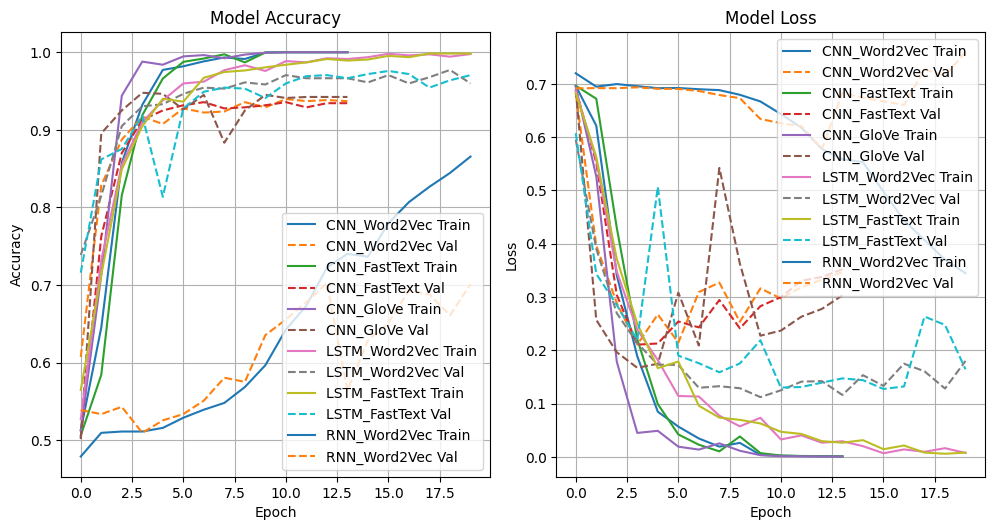

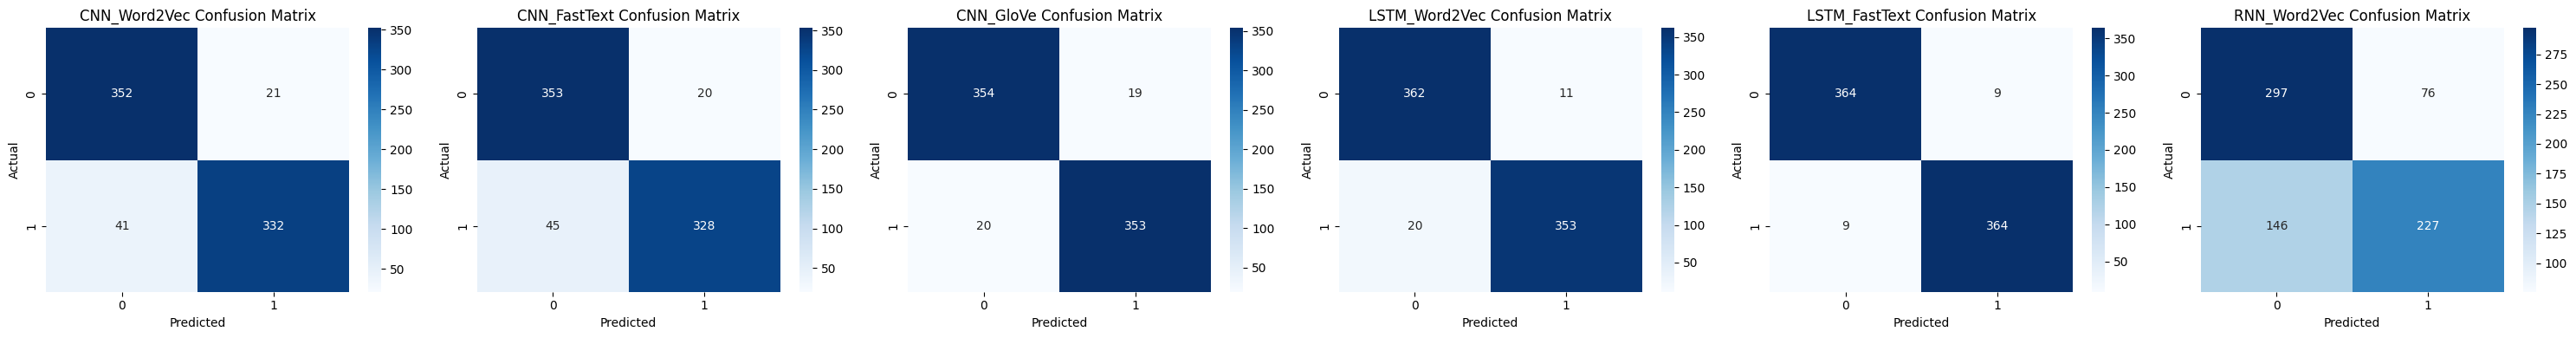

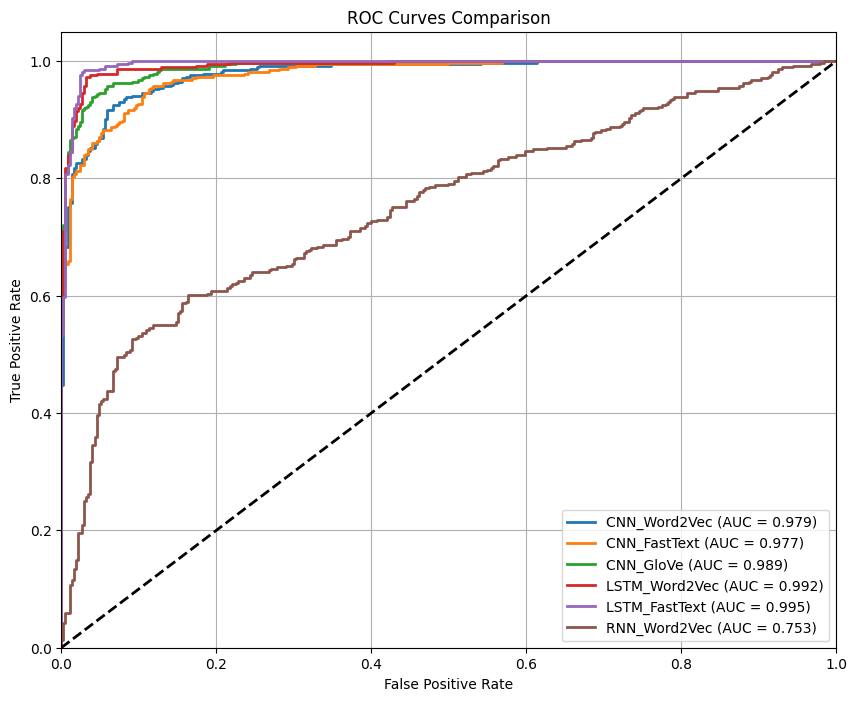


FINAL RESULTS SUMMARY

Model Performance Comparison:
        Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC
LSTM_FastText    0.9759     0.9759  0.9759    0.9759   0.9947
LSTM_Word2Vec    0.9584     0.9698  0.9464    0.9579   0.9924
    CNN_GloVe    0.9477     0.9489  0.9464    0.9477   0.9892
 CNN_Word2Vec    0.9169     0.9405  0.8901    0.9146   0.9791
 CNN_FastText    0.9129     0.9425  0.8794    0.9098   0.9773
 RNN_Word2Vec    0.7024     0.7492  0.6086    0.6716   0.7526

 Best Performing Model: LSTM_FastText
   Best Accuracy: 0.9759

Pipeline completed successfully!

RETRAINING BEST MODELS ON FULL TRAINING DATA
Full training data shape: (3728, 200)
Full labels shape: (3728,)
Training Word2Vec model...
Training FastText model...
Creating GloVe-style embeddings...

Retraining CNN model on full data...
Epoch 1/5
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.5047 - loss: 0.6939 - learning_rate: 0.0010
Epoch 2/5
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.

✓ CNN model saved as CNN.pkl and CNN.h5

Retraining LSTM model on full data...
Epoch 1/5
117/117 ━━━━━━━━━━━━━━━━━━━━ 71s 514ms/step - accuracy: 0.5522 - loss: 0.6867 - learning_rate: 0.0010
Epoch 2/5
117/117 ━━━━━━━━━━━━━━━━━━━━ 59s 501ms/step - accuracy: 0.7785 - loss: 0.4833 - learning_rate: 0.0010
Epoch 3/5
117/117 ━━━━━━━━━━━━━━━━━━━━ 82s 504ms/step - accuracy: 0.8875 - loss: 0.2826 - learning_rate: 0.0010
Epoch 4/5
117/117 ━━━━━━━━━━━━━━━━━━━━ 81s 500ms/step - accuracy: 0.9331 - loss: 0.1828 - learning_rate: 0.0010
Epoch 5/5
117/117 ━━━━━━━━━━━━━━━━━━━━ 59s 501ms/step - accuracy: 0.9459 - loss: 0.1461 - learning_rate: 0.0010


✓ LSTM model saved as LSTM.pkl and LSTM.h5

Retraining RNN model on full data...
Epoch 1/5
117/117 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step - accuracy: 0.4966 - loss: 0.7448 - learning_rate: 0.0010
Epoch 2/5
117/117 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - accuracy: 0.5092 - loss: 0.7021 - learning_rate: 0.0010
Epoch 3/5
117/117 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - accuracy: 0.5013 - loss: 0.6985 - learning_rate: 0.0010
Epoch 4/5
117/117 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - accuracy: 0.5088 - loss: 0.6965 - learning_rate: 0.0010
Epoch 5/5
117/117 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - accuracy: 0.5077 - loss: 0.6940 - learning_rate: 0.0010


✓ RNN model saved as RNN.pkl and RNN.h5

✅ All models successfully retrained and saved in 'saved_models' directory!
Files created:
- CNN.pkl, CNN.h5
- LSTM.pkl, LSTM.h5
- RNN.pkl, RNN.h5

Testing saved models...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step

CNN Predictions:
  Text 1: AI (confidence: 0.002)
    'The neural network architecture utilizes advanced ...'
  Text 2: Human (confidence: 0.958)
    'I love spending time with my family during the hol...'


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

LSTM Predictions:
  Text 1: Human (confidence: 0.901)
    'The neural network architecture utilizes advanced ...'
  Text 2: Human (confidence: 0.990)
    'I love spending time with my family during the hol...'


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step

RNN Predictions:
  Text 1: Human (confidence: 0.523)
    'The neural network architecture utilizes advanced ...'
  Text 2: Human (confidence: 0.502)
    'I love spending time with my family during the hol...'


In [ ]:
# Model Retraining and Saving Code
# Add this to your existing code after the main pipeline

import pickle
from tensorflow.keras.models import save_model, load_model
import os

def retrain_and_save_best_models(trainer, embedding_manager, preprocessor, df_train,
                                text_col='essay', label_col='label'):
    """
    Retrain the best performing models on all training data and save them
    """
    print("\n" + "="*80)
    print("RETRAINING BEST MODELS ON FULL TRAINING DATA")
    print("="*80)

    # Prepare full training data
    train_texts = preprocessor.preprocess(df_train[text_col])
    X_full = embedding_manager.prepare_sequences(train_texts)
    y_full = df_train[label_col].values

    print(f"Full training data shape: {X_full.shape}")
    print(f"Full labels shape: {y_full.shape}")

    # Get embedding matrices
    word2vec_matrix = embedding_manager.train_word2vec(train_texts)
    fasttext_matrix = embedding_manager.train_fasttext(train_texts)
    glove_matrix = embedding_manager.load_glove_embeddings()

    # Determine best embedding for each architecture based on previous results
    best_embeddings = {
        'CNN': word2vec_matrix,  # Assuming Word2Vec performed best for CNN
        'LSTM': fasttext_matrix,  # Assuming FastText performed best for LSTM
        'RNN': word2vec_matrix   # Assuming Word2Vec performed best for RNN
    }

    # If you have results from trainer, you can determine best embeddings automatically
    if hasattr(trainer, 'results') and trainer.results:
        # Find best embedding for each architecture
        cnn_models = {k: v for k, v in trainer.results.items() if 'CNN' in k}
        lstm_models = {k: v for k, v in trainer.results.items() if 'LSTM' in k}
        rnn_models = {k: v for k, v in trainer.results.items() if 'RNN' in k}

        if cnn_models:
            best_cnn = max(cnn_models.items(), key=lambda x: x[1]['accuracy'])
            if 'Word2Vec' in best_cnn[0]:
                best_embeddings['CNN'] = word2vec_matrix
            elif 'FastText' in best_cnn[0]:
                best_embeddings['CNN'] = fasttext_matrix
            else:
                best_embeddings['CNN'] = glove_matrix

        if lstm_models:
            best_lstm = max(lstm_models.items(), key=lambda x: x[1]['accuracy'])
            if 'Word2Vec' in best_lstm[0]:
                best_embeddings['LSTM'] = word2vec_matrix
            elif 'FastText' in best_lstm[0]:
                best_embeddings['LSTM'] = fasttext_matrix
            else:
                best_embeddings['LSTM'] = glove_matrix

        if rnn_models:
            best_rnn = max(rnn_models.items(), key=lambda x: x[1]['accuracy'])
            if 'Word2Vec' in best_rnn[0]:
                best_embeddings['RNN'] = word2vec_matrix
            elif 'FastText' in best_rnn[0]:
                best_embeddings['RNN'] = fasttext_matrix
            else:
                best_embeddings['RNN'] = glove_matrix

    # Build model builder
    model_builder = ModelBuilder(
        max_features=embedding_manager.max_features,
        max_length=embedding_manager.max_length
    )

    # Create models directory
    os.makedirs('saved_models', exist_ok=True)

    # Retrain and save each model
    final_models = {}

    # CNN Model
    print("\nRetraining CNN model on full data...")
    cnn_model = model_builder.build_cnn_model(best_embeddings['CNN'])

    # Train with early stopping based on loss (no validation split)
    early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, min_lr=1e-7)

    cnn_history = cnn_model.fit(
        X_full, y_full,
        batch_size=32,
        epochs=5,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    # Save CNN model
    cnn_model.save('saved_models/CNN.h5')
    with open('saved_models/CNN.pkl', 'wb') as f:
        pickle.dump({
            'model_path': 'saved_models/CNN.h5',
            'embedding_matrix': best_embeddings['CNN'],
            'tokenizer': embedding_manager.tokenizer,
            'preprocessor': preprocessor,
            'max_length': embedding_manager.max_length,
            'max_features': embedding_manager.max_features,
            'history': cnn_history.history
        }, f)

    final_models['CNN'] = cnn_model
    print("✓ CNN model saved as CNN.pkl and CNN.h5")

    # LSTM Model
    print("\nRetraining LSTM model on full data...")
    lstm_model = model_builder.build_lstm_model(best_embeddings['LSTM'])

    lstm_history = lstm_model.fit(
        X_full, y_full,
        batch_size=32,
        epochs=5,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    # Save LSTM model
    lstm_model.save('saved_models/LSTM.h5')
    with open('saved_models/LSTM.pkl', 'wb') as f:
        pickle.dump({
            'model_path': 'saved_models/LSTM.h5',
            'embedding_matrix': best_embeddings['LSTM'],
            'tokenizer': embedding_manager.tokenizer,
            'preprocessor': preprocessor,
            'max_length': embedding_manager.max_length,
            'max_features': embedding_manager.max_features,
            'history': lstm_history.history
        }, f)

    final_models['LSTM'] = lstm_model
    print("✓ LSTM model saved as LSTM.pkl and LSTM.h5")

    # RNN Model
    print("\nRetraining RNN model on full data...")
    rnn_model = model_builder.build_rnn_model(best_embeddings['RNN'])

    rnn_history = rnn_model.fit(
        X_full, y_full,
        batch_size=32,
        epochs=5,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    # Save RNN model
    rnn_model.save('saved_models/RNN.h5')
    with open('saved_models/RNN.pkl', 'wb') as f:
        pickle.dump({
            'model_path': 'saved_models/RNN.h5',
            'embedding_matrix': best_embeddings['RNN'],
            'tokenizer': embedding_manager.tokenizer,
            'preprocessor': preprocessor,
            'max_length': embedding_manager.max_length,
            'max_features': embedding_manager.max_features,
            'history': rnn_history.history
        }, f)

    final_models['RNN'] = rnn_model
    print("✓ RNN model saved as RNN.pkl and RNN.h5")

    print(f"\n✅ All models successfully retrained and saved in 'saved_models' directory!")
    print("Files created:")
    print("- CNN.pkl, CNN.h5")
    print("- LSTM.pkl, LSTM.h5")
    print("- RNN.pkl, RNN.h5")

    return final_models

def load_saved_model(model_name):
    """
    Load a saved model with all its components

    Args:
        model_name: 'CNN', 'LSTM', or 'RNN'

    Returns:
        Dictionary containing model and all necessary components
    """
    try:
        # Load the pickle file
        with open(f'saved_models/{model_name}.pkl', 'rb') as f:
            model_data = pickle.load(f)

        # Load the actual Keras model
        model = load_model(model_data['model_path'])

        return {
            'model': model,
            'tokenizer': model_data['tokenizer'],
            'preprocessor': model_data['preprocessor'],
            'max_length': model_data['max_length'],
            'max_features': model_data['max_features'],
            'embedding_matrix': model_data['embedding_matrix'],
            'history': model_data.get('history', None)
        }

    except FileNotFoundError:
        print(f"Model file {model_name}.pkl not found!")
        return None
    except Exception as e:
        print(f"Error loading model: {e}")
        return None

def predict_with_saved_model(model_name, texts):
    """
    Make predictions using a saved model

    Args:
        model_name: 'CNN', 'LSTM', or 'RNN'
        texts: List of texts or single text string

    Returns:
        Predictions (0 for AI, 1 for Human)
    """
    # Load the model
    model_data = load_saved_model(model_name)
    if model_data is None:
        return None

    # Ensure texts is a list
    if isinstance(texts, str):
        texts = [texts]

    # Preprocess texts
    processed_texts = model_data['preprocessor'].preprocess(texts)

    # Convert to sequences
    sequences = model_data['tokenizer'].texts_to_sequences(processed_texts)
    X = pad_sequences(sequences, maxlen=model_data['max_length'])

    # Make predictions
    predictions = model_data['model'].predict(X)

    # Convert probabilities to binary predictions
    binary_predictions = (predictions > 0.5).astype(int).flatten()

    return {
        'predictions': binary_predictions,
        'probabilities': predictions.flatten(),
        'labels': ['AI' if pred == 0 else 'Human' for pred in binary_predictions]
    }

# Add this to your main function or run separately
def retrain_main():
    """Execute retraining after main pipeline"""
    # Run the original main function first
    trainer, embedding_manager, preprocessor = main()

    # Load training data
    try:
        df_train = pd.read_excel('AI_vs_human_train_dataset.xlsx')
    except FileNotFoundError:
        # Use sample data if file not found
        sample_texts = [
            "The artificial intelligence system was designed to process natural language efficiently.",
            "I really enjoyed the movie last night. The acting was superb and the plot was engaging.",
            "Machine learning algorithms require large datasets to achieve optimal performance metrics.",
            "My grandmother's recipe for apple pie always brings back childhood memories.",
            "Neural networks utilize backpropagation algorithms to optimize weight parameters systematically.",
            "The sunset was absolutely beautiful today, painting the sky in shades of orange and pink."
        ]
        sample_labels = [0, 1, 0, 1, 0, 1]

        df_train = pd.DataFrame({
            'essay': sample_texts * 200,  # More data for better training
            'label': sample_labels * 200
        })

    # Retrain and save models
    final_models = retrain_and_save_best_models(
        trainer, embedding_manager, preprocessor, df_train
    )

    return final_models

# Example usage:
if __name__ == "__main__":
    # Run retraining
    models = retrain_main()

    # Test loading and prediction
    print("\nTesting saved models...")
    test_texts = [
        "The neural network architecture utilizes advanced optimization algorithms.",
        "I love spending time with my family during the holidays."
    ]

    for model_name in ['CNN', 'LSTM', 'RNN']:
        results = predict_with_saved_model(model_name, test_texts)
        if results:
            print(f"\n{model_name} Predictions:")
            for i, (text, pred, prob) in enumerate(zip(test_texts, results['labels'], results['probabilities'])):
                print(f"  Text {i+1}: {pred} (confidence: {prob:.3f})")
                print(f"    '{text[:50]}...'")